<a href="https://colab.research.google.com/github/SajidKhan833/Big-Data/blob/main/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [8]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import os
import cv2

%matplotlib inline

In [18]:
path = '/content/fer2013.csv'
data = pd.read_csv(path)
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


This dataset is about finding the right emotion. There are seven universal facial emotions (according to many studies; some modern studies might not agree): happy, sad, angry, afraid, surprise,disgust, and neutral

In [19]:
data['Usage'].value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [22]:
# Check if there are any null entries
train = data[["emotion", "pixels"]][data["Usage"] == "Training"]
train.isnull().sum()

,0
emotion,0
pixels,0


In [21]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [23]:
train['pixels'][0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [24]:
#For validation
print(data['Usage'].unique()) # Print unique values in 'Usage' to check for typos

# Based on the output of the print statement, correct the filtering condition
# For example, if the output shows ' public test', change "PublicTest" to " public test"
public_test_df = data[["emotion", "pixels"]][data["Usage"]=="PublicTest"] # Replace "PublicTest" with the correct string if necessary

# Check if public_test_df is still empty and handle accordingly
if public_test_df.empty:
    print("Warning: Public test dataset is empty. Validation will be skipped or handled differently.")
    # Add logic here to handle the empty validation set, e.g., skip validation or use a different subset
else:
    public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
    x_val = np.vstack(public_test_df["pixels"].values)
    y_val = np.array(public_test_df["emotion"])

    x_val.shape, y_val.shape

['Training' 'PublicTest' 'PrivateTest']


In [25]:
#Data in usable format
x_train = x_train.reshape(-1, 48, 48, 1)
x_val = x_val.reshape(-1, 48, 48, 1)
x_train.shape, x_val.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [31]:
y_train[5]

array([0., 0., 1., 0., 0., 0., 0.])

In [27]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_train.shape, y_val.shape

((28709, 7), (3589, 7))

In [30]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.])

In [33]:

class_names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

<function matplotlib.pyplot.show(close=None, block=None)>

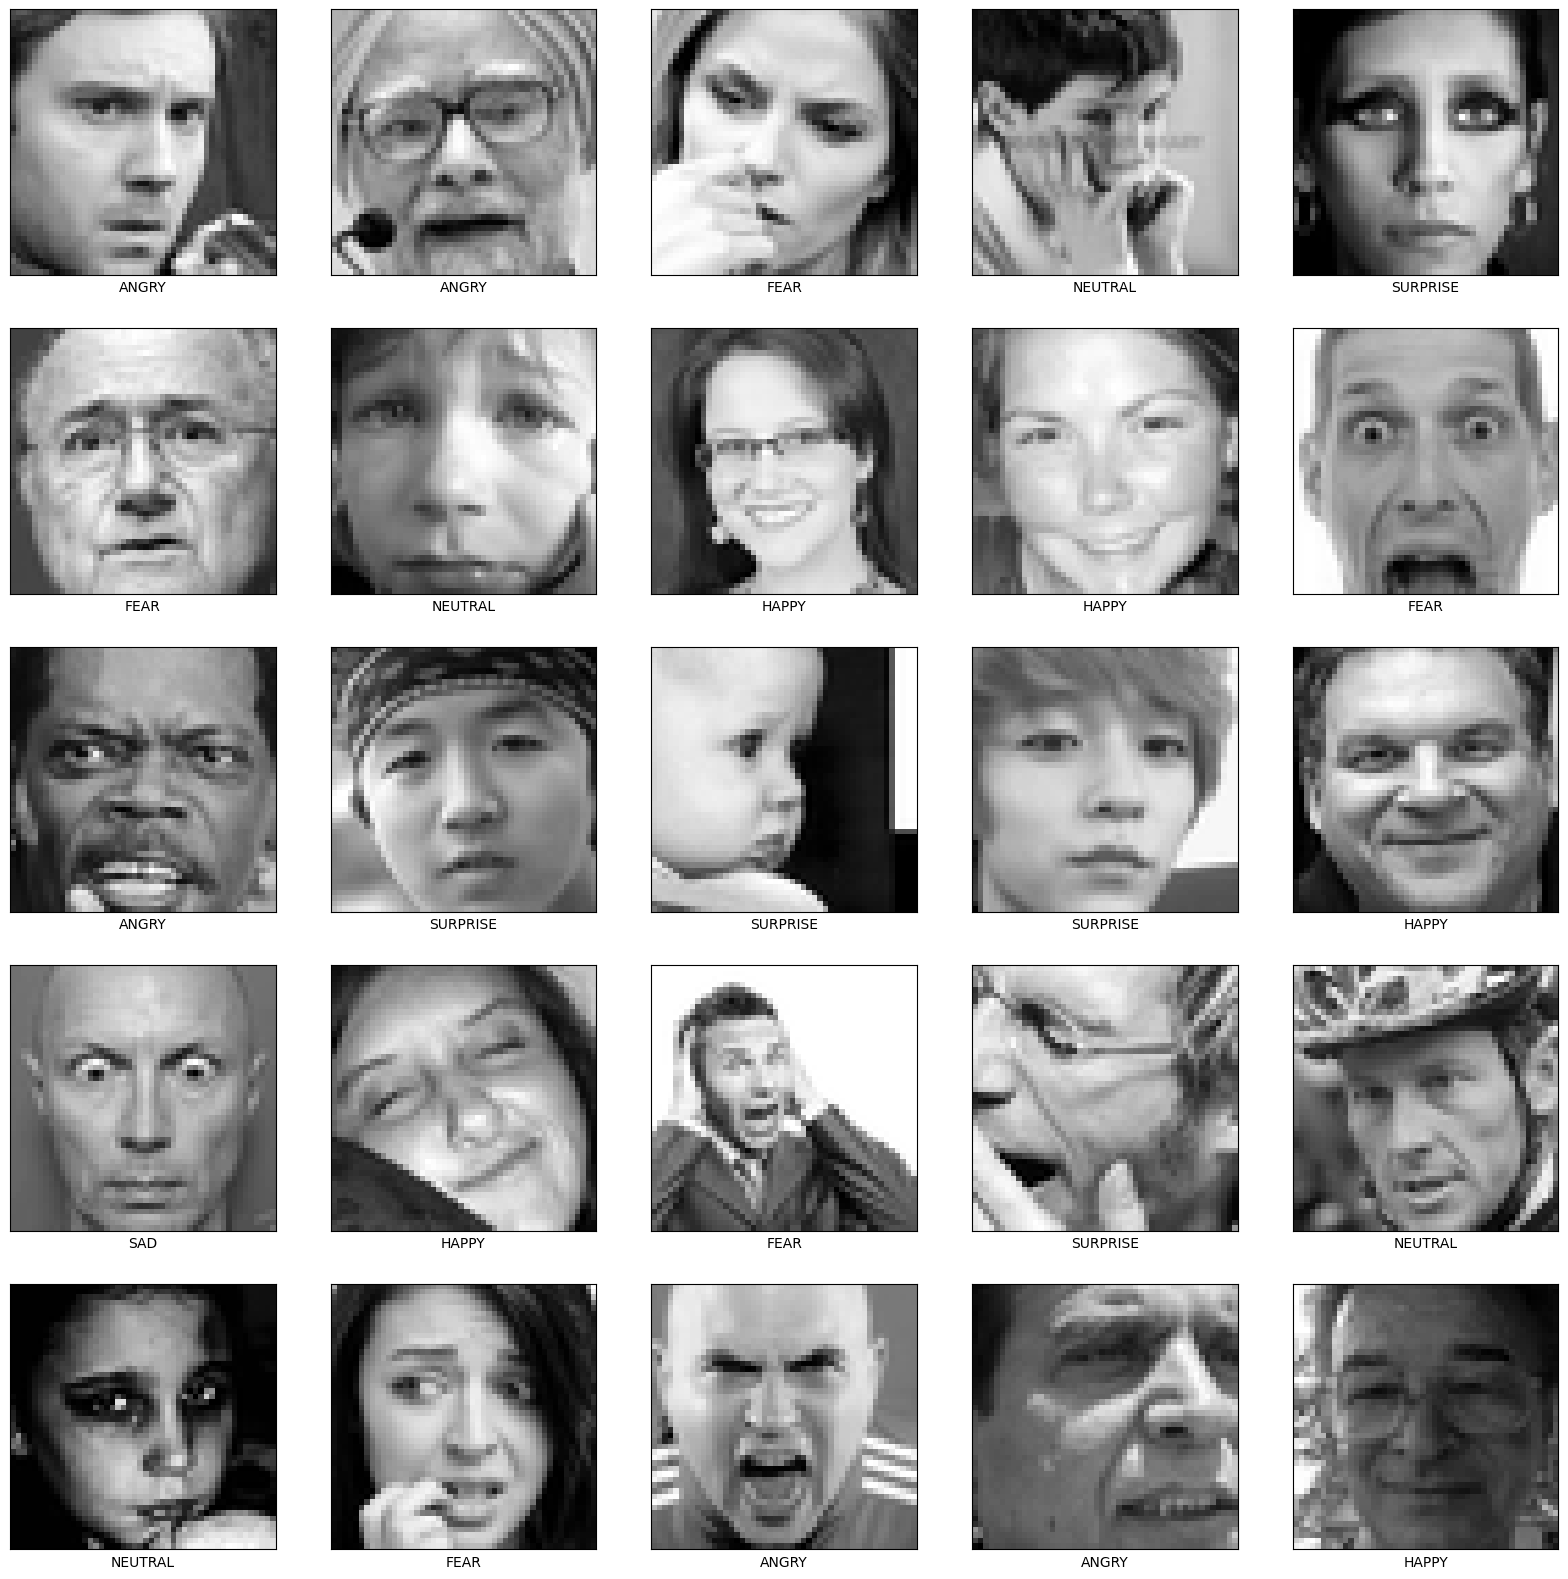

In [34]:
#Here we are going to display the data
# TO See how it looks like
# Earlier we re-format the data and each image dimension = (48,48,1)
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # matplot lib's plt need this to be squeezed into (48,48); otherwise it will show an error.
    plt.imshow(np.squeeze(x_train[i]), cmap='gray')
    plt.xlabel(class_names[np.argmax(y_train[i])])
plt.show

In [35]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 60

This below network design is inspired from a refernce with a little bit of tweaking.


In [36]:
# For training without AUGmentation: 0.5 for dropout layer was used. Less data and overfitting was the reason.

model = keras.Sequential ([
    keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(2*2*2*num_features, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(2*2*num_features, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2*num_features, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(7, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 44, 44, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 44, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 42, 42, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 40, 40, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 40, 40, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,051,591 (34.53 MB)

 Trainable params: 9,047,879 (34.51 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks
#earlyStopping = EarlyStopping(monitor='val_loss', patience=5)
#mcp_save = ModelCheckpoint('/content/drive/My Drive/dataFiles', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=7, min_lr=0.0001)

In [ ]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[ reduce_lr_loss], validation_data=(x_val, y_val), shuffle=True)

Train on 28709 samples, validate on 3589 samples
Epoch 1/60
28709/28709 [==============================] - 20s 714us/sample - loss: 1.9485 - accuracy: 0.2381 - val_loss: 1.6896 - val_accuracy: 0.3207
Epoch 2/60
28709/28709 [==============================] - 19s 654us/sample - loss: 1.6700 - accuracy: 0.3353 - val_loss: 1.7212 - val_accuracy: 0.3135
Epoch 3/60
28709/28709 [==============================] - 19s 653us/sample - loss: 1.5157 - accuracy: 0.4067 - val_loss: 1.5622 - val_accuracy: 0.3840
Epoch 4/60
28709/28709 [==============================] - 19s 654us/sample - loss: 1.3947 - accuracy: 0.4661 - val_loss: 1.3307 - val_accuracy: 0.4904
Epoch 5/60
28709/28709 [==============================] - 19s 654us/sample - loss: 1.3159 - accuracy: 0.5017 - val_loss: 1.4697 - val_accuracy: 0.4294
Epoch 6/60
28709/28709 [==============================] - 19s 653us/sample - loss: 1.2634 - accuracy: 0.5226 - val_loss: 1.2265 - val_accuracy: 0.5300
Epoch 7/60
28709/28709 [=====================

3589/3589 - 1s - loss: 2.9715 - accuracy: 0.6467


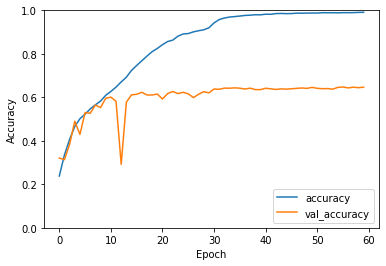

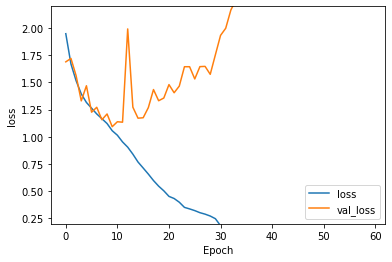

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.figure()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.2, 2.2])
plt.legend(loc='lower right')
plt.figure()

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)

**What can we learn from this graph?**
>
After 15th epoch, accuracy is almost constant and lass has gone way too high.

I should have employed earlystopping here but in previous runs of the model it didnot help alot. So, i will try it with image augmentation below.

In [ ]:
predictions = model.predict(x_val)

<function matplotlib.pyplot.show>

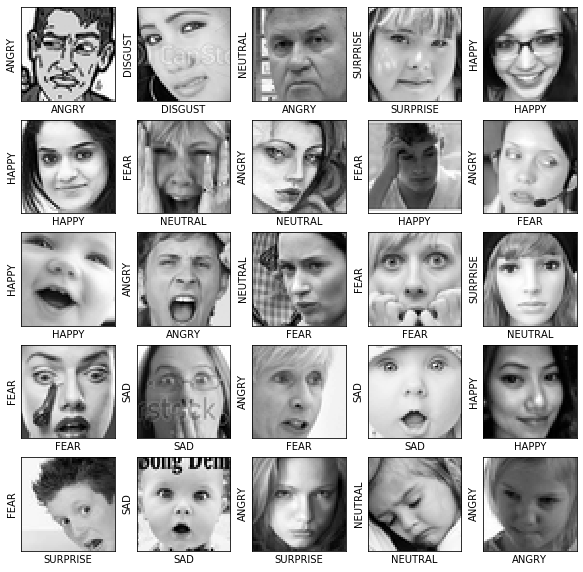

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_val[i]), cmap='gray')
    plt.xlabel(class_names[np.argmax(predictions[i])])
    plt.ylabel(class_names[np.argmax(y_val[i])])
plt.show

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   #vertical_flip = True,
                                   fill_mode = 'mirror')



###############
test_datagen = ImageDataGenerator(rescale = 1./255.,)

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [ ]:

# Callbacks
earlyStopping = EarlyStopping(monitor='val_loss', patience=5)
mcp_save = ModelCheckpoint('/content/drive/My Drive/', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.0001)

In [ ]:
# run model
hist = model.fit_generator( train_datagen.flow(x_train, y_train, batch_size=batch_size), epochs=60,
                 shuffle=True,
                 steps_per_epoch=len(x_train) // batch_size,
                 callbacks=[reduce_lr_loss],
                 validation_data=test_datagen.flow(x_val, y_val),
                 verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 448 steps, validate for 113 steps
Epoch 1/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8950 - acc: 0.6770 - val_loss: 0.9730 - val_acc: 0.6506
Epoch 2/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8904 - acc: 0.6787 - val_loss: 0.9690 - val_acc: 0.6517
Epoch 3/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8882 - acc: 0.6813 - val_loss: 0.9593 - val_acc: 0.6512
Epoch 4/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8772 - acc: 0.6808 - val_loss: 0.9655 - val_acc: 0.6539
Epoch 5/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8770 - acc: 0.6826 - val_loss: 0.9632 - val_acc: 0.6545
Epoch 6/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8675 - acc: 0.6872 - val_loss: 0.9704 - val_acc: 0.6520
Epoch 7/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8631 - acc: 0.6859 - val

3589/3589 - 1s - loss: 1305.0497 - acc: 0.2616


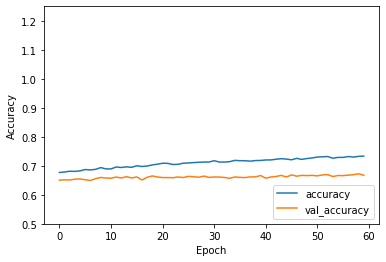

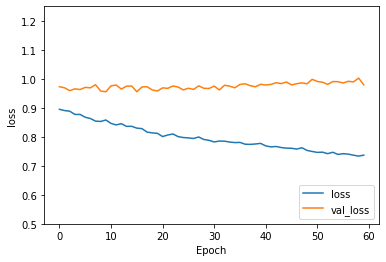

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['acc'], label='accuracy')
plt.plot(hist.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.25])
plt.legend(loc='lower right')
plt.figure()


plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.5, 1.25])
plt.legend(loc='lower right')
plt.figure()

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)

**What to learn from above graphs:**

hmmm... This graph is acheived after a number of run of the model to acheive a better accuracy. Validation loss is under 1 now and validation accuracy has shown some improvement too.

<function matplotlib.pyplot.show>

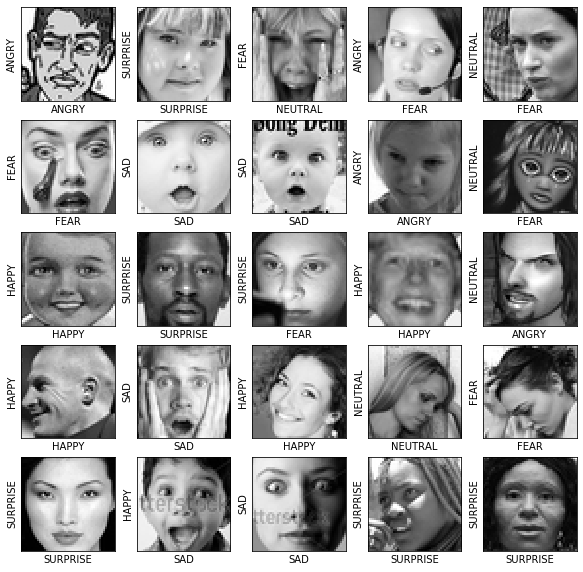

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_val[i*3]), cmap='gray')
    plt.xlabel(class_names[np.argmax(predictions[i*3])])
    plt.ylabel(class_names[np.argmax(y_val[i*3])])
plt.show

**7** among 25 from the validation set are worng pedicted. This is not good. However the best accuracies acheived on this dataset (according to my knowledge) are not upto the mark.


#Now preprocessing for Transfer Learning.
Networks like resnet, densenet, vgg etc are trained on rgb image. Fer is a gray scale image they expect a 3dimenional image and usually in a greater size. Increasing size of the image might lead to decreased accuracy but this is the trade-odd we will have to bear with this dataset.

In [ ]:
#Making photos 3-dimensional.
print ('before the shape is {}'.format(x_train.shape))
tChannel = np.squeeze(x_train)
tChannel = np.repeat(tChannel[..., np.newaxis],3,-1)
print ('After the shape is {}'.format(tChannel.shape))

'''
#TF's method to decrease overall size.
sI=tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(x_train),
    name=None
)
'''
#############################################
#valiation set to 3-dimensions
#Making photos 3-dimensional.
print ('before the shape is {}'.format(x_val.shape))
tVal = np.squeeze(x_val)
tVal = np.repeat(tVal[..., np.newaxis],3,-1)
print ('After the shape is {}'.format(tVal.shape))


before the shape is (28709, 48, 48, 1)
After the shape is (28709, 48, 48, 3)
before the shape is (3589, 48, 48, 1)
After the shape is (3589, 48, 48, 3)


In [ ]:
img_height, img_width = 120, 120
from skimage.transform import resize
x_train3 = tf.image.resize(tChannel, [img_height, img_width])

#resizing the validation set below
x_val3 = tf.image.resize(tVal, [img_height, img_width])
#print('x_val3 size is: {} : x_train3 is {}'.format(nValBatch.shape, x_train3.shape))

In [ ]:
print('x_train3 size is: {} : x_val3 : {}'.format(x_train3.shape, x_val3.shape))

x_train3 size is: (28709, 120, 120, 3) : x_val3 : (3589, 120, 120, 3)


In [ ]:
#from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121

In [ ]:
base_model =DenseNet121(
    include_top = True,
    weights     = None,
    input_shape = (img_height, img_width, 3))

In [ ]:
base_model.load_weights('/content/drive/My Drive/DenseNet-BC-121-32.h5')

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 126, 126, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 60, 60, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 60, 60, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
last_layer = base_model.get_layer('pool4_conv')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [ ]:
#x = tf.keras.layers.BatchNormalization()
#x = tf.keras.layers.GlobalAveragePooling2D

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (7, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   #shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   #vertical_flip = True,
                                   fill_mode = 'nearest')



###############
test_datagen = ImageDataGenerator(rescale = 1./255.,)

In [ ]:
# run model
hist = model.fit_generator( train_datagen.flow(x_train3, y_train, batch_size=batch_size), epochs=epochs,
                 shuffle=True,
                 steps_per_epoch=len(x_train3) // batch_size,
                 callbacks=[earlyStopping, reduce_lr_loss],
                 validation_data=test_datagen.flow(x_val3, y_val),
                 verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 448 steps, validate for 113 steps
Epoch 1/60
448/448 [==============================] - 95s 212ms/step - loss: 1.0325 - acc: 0.6111 - val_loss: 1.4874 - val_acc: 0.4882
Epoch 2/60
448/448 [==============================] - 96s 214ms/step - loss: 1.0233 - acc: 0.6179 - val_loss: 1.4938 - val_acc: 0.4884
Epoch 3/60
448/448 [==============================] - 96s 215ms/step - loss: 1.0219 - acc: 0.6165 - val_loss: 1.4672 - val_acc: 0.4901
Epoch 4/60
448/448 [==============================] - 97s 216ms/step - loss: 1.0181 - acc: 0.6197 - val_loss: 1.4795 - val_acc: 0.4843
Epoch 5/60
448/448 [==============================] - 97s 216ms/step - loss: 1.0196 - acc: 0.6156 - val_loss: 1.4664 - val_acc: 0.4901
Epoch 6/60
448/448 [==============================] - 97s 216ms/step - loss: 1.0129 - acc: 0.6233 - val_loss: 1.4987 - val_acc: 0.4870
Epoch 7/60
448/448 [==============================] - 97s 217ms/step - loss: 1.0153 - acc: 0.618


Transfer learning did not help to improve overall scores. I have tried with removing and including top layers, image augmentation and so on. The best i could get was 51 on validation set.

-- If considered to move with transfer learning in near future:
1.   consider retraining the 1st layer. Again, not recommended but some people find it to be useful.
2. Consider retraining the network and compare the performance)

